In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import typing as t
from cycler import cycler
import numpy as np

In [2]:
df = pd.read_csv("data/ExperimentLogs.csv")

In [7]:
def allowed_versions(df, dataset, versions):
    return (df["dataset"] == dataset) & (df["repo_hash"].isin(versions))

# Select the experiments that we want to compare
selected = df[ (df["strategy"] == "taskInference") &
    # (df["experiment_category"].isin(["PL", "EP", "prunelevels"])) &
    # (df["prune_proportion"] == "0.5") &
    (
        allowed_versions(df, "S-FMNIST", {"1555acb6", "0a229afa", "4e7023cd", "4e7023cdD", "0a229afaD", "54dcf601"}) |
        allowed_versions(df, "S-CIFAR10", {"1555acb6", "0a229afa", "4e7023cd", "4e7023cdD", "0a229afaD"}) |
        allowed_versions(df, "S-CIFAR100", {"1555acb6", "0a229afa", "4e7023cd", "4e7023cdD", "0a229afaD"}) |
        allowed_versions(df, "S-CORe50", {"84260321", "a6134f6c", "a3411a3b", "ecc57a24"}) |
        allowed_versions(df, "SE-CIFAR100", {"84260321", "a6134f6c", "a3411a3b", "ecc57a24"}) |
        allowed_versions(df, "SE-CORe50", {"84260321", "a6134f6c", "a3411a3b", "ecc57a24"})
    ) &
    (df["completed_tasks"] == df["n_experiences"])
]


idx = selected.groupby(["prune_proportion", "dataset", "architecture"])["final_accuracy"].mean().groupby("dataset").idxmax()
for prune_proportion, dataset, architecture in idx:
    # Refine selection
    selected = selected[
        ((selected["prune_proportion"] == prune_proportion) &
        (selected["architecture"] != architecture)) |
        (selected["dataset"] != dataset)
    ]

In [8]:
# Use cubehelix to get a nice color palette
colours = plt.cm.cubehelix(np.linspace(0.1, 0.9, 5))
plt.rcParams['axes.prop_cycle'] = cycler(color=colours)

from matplotlib import font_manager
import os
font_dirs = [f"{os.path.expanduser('~')}/.fonts/ttf/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs, fontext='ttf')
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)


plt.rcParams['font.family'] = 'IBM Plex Sans'

# Set dpi
plt.rcParams['figure.dpi'] = 300

/tmp/ipykernel_1015472/1157393338.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{x*100:.0f}%" for x in ax.get_yticks()])


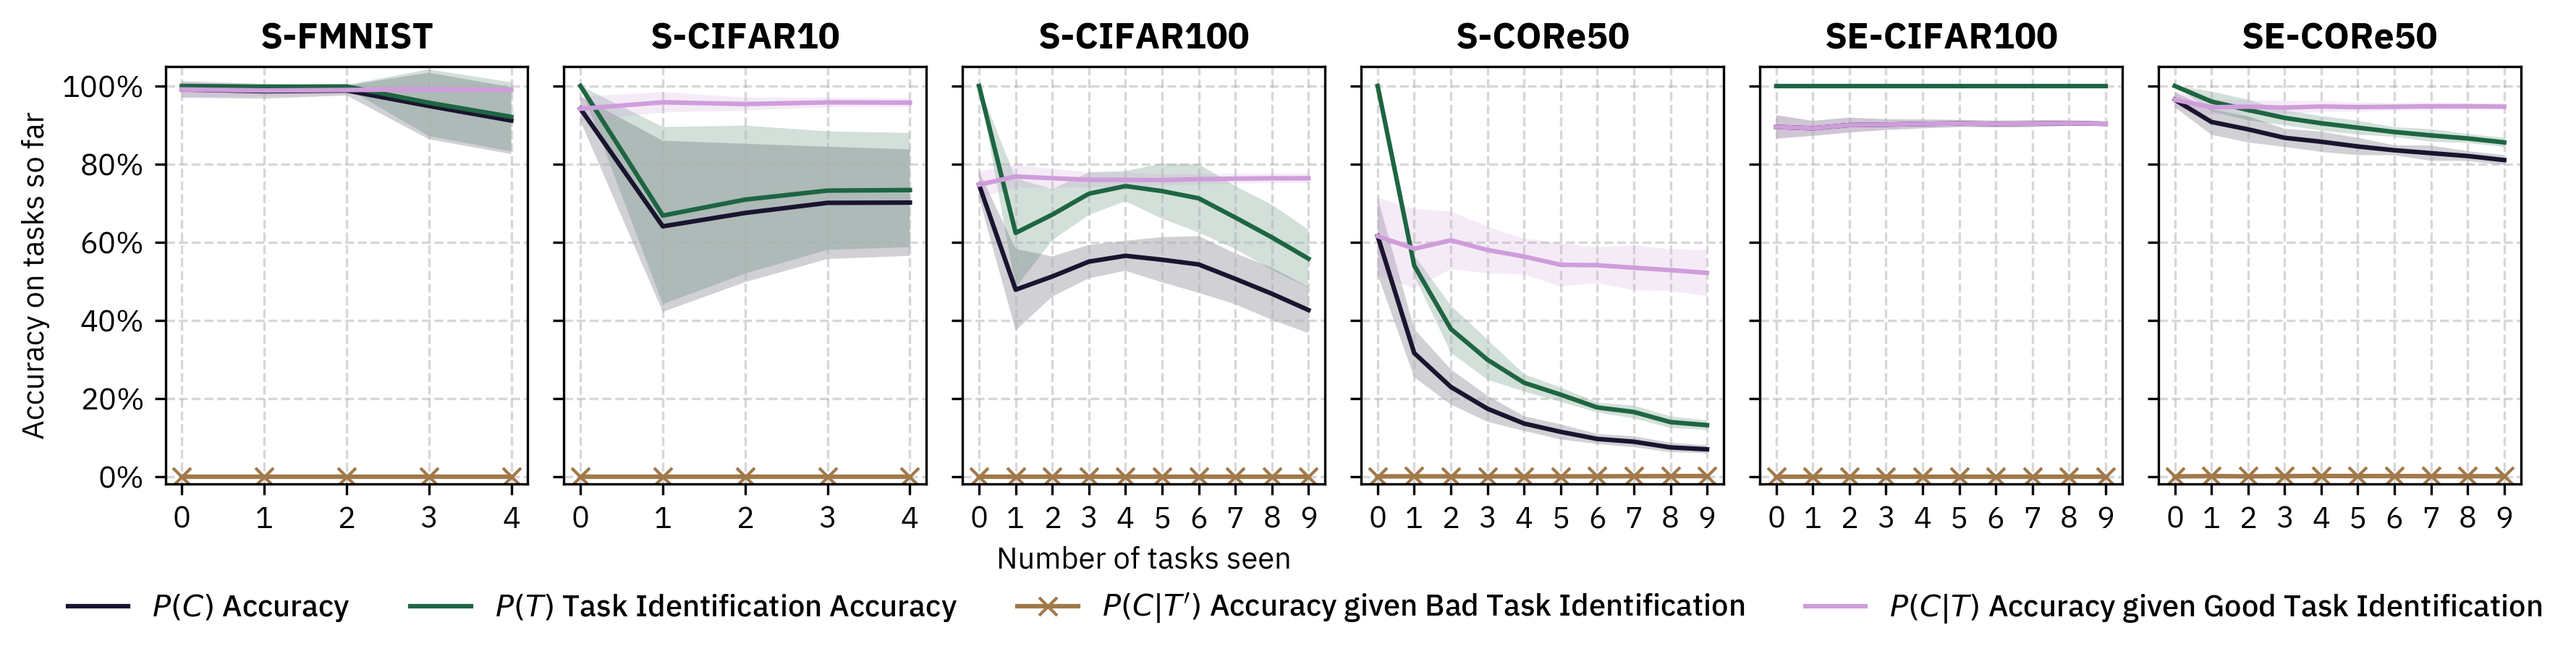

In [12]:
def mean_std(series: t.List[t.List[float]]):
    mean = [sum(x) / len(x) for x in zip(*series)]
    std = [np.std(x) for x in zip(*series)]
    return mean, std

def plot_with_std(ax, mean: t.List[float], std: t.List[float], label: str = None, style: str = "-"):
    ax.fill_between(range(len(mean)), np.subtract(mean, std), np.add(mean, std), alpha=0.2)
    return ax.plot(mean, style, label=label)

def eval_series(series):
    return series.apply(lambda x: eval(x, {"nan": 0}))

# Create 5 plots side by side
fig, axs = plt.subplots(1, 6, figsize=(14, 2.5), sharey=True)
fig.subplots_adjust(wspace=0.1)


# Loop over each dataset
for dataset, ax in zip(
    ["S-FMNIST", "S-CIFAR10", "S-CIFAR100", "S-CORe50", "SE-CIFAR100", "SE-CORe50"]
    , axs):

    # Select the data for the current dataset
    data = selected[selected["dataset"] == dataset]
    n_experiences = int(data["n_experiences"].iloc[0])

    def _get_metric(key):
        return mean_std(eval_series(data[key]))


    # Plot the mean and std for each metric
    plot_with_std(ax, *_get_metric("accuracy"), 
        label="$P(C)$ Accuracy",
    )
    plot_with_std(ax, *_get_metric("Task Identification Accuracy"), 
        label="$P(T)$ Task Identification Accuracy",

    ),
    plot_with_std(ax, *_get_metric("Accuracy given Bad Task Identification"),
        label="$P(C|T')$ Accuracy given Bad Task Identification",
        style="-x"
    )
    plot_with_std(ax, *_get_metric("Accuracy given Good Task Identification"),
        label="$P(C|T)$ Accuracy given Good Task Identification",
    )


    ax.set_ylim(-0.02, 1.05)
    ax.set_title(dataset, fontsize=12, fontweight="bold")
    # Add grid dashed
    ax.grid(True, linestyle='--', alpha=0.5)
    # x ticks
    ax.set_xticks(range(0, n_experiences, 1))
    # Make percentage
    ax.set_yticklabels([f"{x*100:.0f}%" for x in ax.get_yticks()])
    

axs[0].set_ylabel("Accuracy on tasks so far")
axs[2].set_xlabel("Number of tasks seen")

# Add legend
fig.legend(
    *axs[0].get_legend_handles_labels(),
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.2),
    frameon=False,
    # Bold
    prop={"weight": "medium"}
)


# Save to pdf
plt.savefig("taskAccuracy.pdf", bbox_inches="tight", pad_inches=0)